# Firo forensics

Isthmus // March 2021

This research examines the large reorganization of the Firo chain in Jan 2021. The relevant background for understanding this analysis is discussed in the post-mortem: [https://forum.firo.org/t/firo-51-attack-post-mortem-and-vote-on-attackers-funds/1084](https://forum.firo.org/t/firo-51-attack-post-mortem-and-vote-on-attackers-funds/1084)

Since a reorganization of this type is considered a "50%+1 attack" on Nakamoto consensus, we will adopt the technical term and refer to the "attacker's" blocks versus the control case of general chain statistics.

First, we'll conclusively identify which blocks were mined by the attacker based on two signature types: the miner address, and a fingerprint on the coinbase transaction.
They were mainly active during a 357 block window from 338403 to 338760. During that time, they mined 98.6% of blocks. The only blocks in that interval that they did not mine were: 338720, 338750, 338753, 338756, 338759.
Further examination of blocks mined in 2021 did not show any trace of either fingerprint outside of 338403-338760 with the single exception of block 337396 which contained the coinbase fingerprint but a different miner address.

Second, we'll analyze the nonces and observe that the attacker employed a nonce search strategy of starting at zero and incrementing upwards with each hash (one of four strategies observed in the wild in the Firo ecosystem).
The nonces in the attacker's blocks are distributed throughout more of the range (relative to the Firo network baseline / control case), which suggests that the attacker achieved the same hashrate with fewer devices.
This phenomenon inspired a miner nonce search strategy simulator that explores this idea further: https://github.com/Mitchellpkt/PoW-search-simulator/blob/main/PoW%20search%20simulator.ipynb


Third, we'll compare the timestamps across the fork to compare progress of the two chains. If the timestamps are accurate, then the attack chain was significantly ahead of the organic chain (by as far as 40+ blocks) for much of the reorganized window.


Questions / comments / suggestions? Contact: firo-forensics@mitchellpkt.com

Support: `aCRUhBHi5WXS9Prq3HbXQkTG7TfHtfUDBx` (Firo)

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import isthmuslib as isli
import numpy as np
import requests as requests
from typing import Tuple, List
import pathlib
from matplotlib import cycler

## Misc

In [2]:
pd.set_option('display.max_rows', 100)

Plot themes

In [3]:
firo_red: Tuple[float, float, float] = (155 / 256, 28 / 256, 46 / 256)
firo_red_array: np.ndarray = np.array([firo_red])
firo_gray: Tuple[float, float, float] = (244 / 256, 244 / 256, 244 / 256)
watermark_text: str = "Isthmus - github.com/mitchellpkt/firo-forensics"
style: isli.Style = isli.Style(color=firo_red, watermark_color='darkslategray', watermark_text=watermark_text,
                               watermark_fontsize=12, figsize=(13,8), watermark_placement=(0.02, 0.94),
                               median_linestyle='-', grid=False)
alt_text_placement: Tuple[float, float] = (0.025, 0.025)

Disable scrolling in Jupyter notebooks

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Import data

In [5]:
active_blocks: pd.DataFrame = pd.read_csv(pathlib.Path.cwd() / '..' / 'data' / 'firo_active_chain.csv', delimiter=';')
abandoned_blocks: pd.DataFrame = pd.read_csv(pathlib.Path.cwd() / '..' / 'data' / 'firo_abandoned.csv', delimiter=';')

Pull out attack blocks

In [6]:
attack_blocks = active_blocks.loc[active_blocks['height'].isin(abandoned_blocks['height']), :].reset_index(drop=True)

## Which blocks did the attacker mine?

The attacker always mined with address `aMmjZpVtThPBV9nSihfw6ryPEQYrx7PTbq` and included the string `anon` in the coinbase transaction.

This next cell will serially query a blockchain explorer for info about the blocks in the range that the miner was online. It is disabled by default to avoid unnecessary pings, set `collect_block_info = True` to activate.

### Approach 1: Collect or insert data based on attacker address

See summary information in output cell

In [7]:
collect_block_info: bool = False
earliest_block: int = 338403  # This is adjusted to set the scan window width
latest_block: int = 338760  # This is adjusted to set the scan window width

if collect_block_info:
    others_heights: List[int] = []
    # Data collection interface not long-term stable, but results cached below
    for h in range(earliest_block, latest_block + 1):
        r = requests.get("https://www.coinexplorer.net/FIRO/block/" + str(h))
        if 'aMmjZpVtThPBV9nSihfw6ryPEQYrx7PTbq' not in r.text:
            others_heights.append(h)
else:
    # Skip the data collection and insert the result
    others_heights: List[int] = [338720, 338750, 338753, 338756, 338759]

attacker_activity_window: int = latest_block - earliest_block + 1
others_count: int = len(others_heights)
attacker_count: int = attacker_activity_window - others_count
attacker_fraction: float = attacker_count / attacker_activity_window

print(f"\n{(n := 50) * '*'}\n{n * '*'}")
print(f'\nThe attacker was active during a {attacker_activity_window} '
      f'block window from  {earliest_block} to  {latest_block})')
print(
    f'\nDuring that time, they mined {attacker_fraction * 100:.1f} % of blocks ({attacker_count} of {attacker_activity_window})')
print(f"\n{(n := 50) * '*'}\n{n * '*'}")


**************************************************
**************************************************

The attacker was active during a 358 block window from  338403 to  338760)

During that time, they mined 98.6 % of blocks (353 of 358)

**************************************************
**************************************************


### Approach 2: Collect or insert data based on coinbase metadata

The attacker's coinbases always end with `4616e6f6e` (`anon`), for example:
+ height 337396 [https://firoblockexplorers.com/tx/44c1f52eb7a8ef417941416f7102e42e1954620211894c01d9c9264279869b73](https://firoblockexplorers.com/tx/44c1f52eb7a8ef417941416f7102e42e1954620211894c01d9c9264279869b73)
+ height 338403 [https://firoblockexplorers.com/tx/ad466dfc1c2b6532c74cd6f8fee4983f7cfac4781ebe4946b97978bdc1fa2745](https://firoblockexplorers.com/tx/ad466dfc1c2b6532c74cd6f8fee4983f7cfac4781ebe4946b97978bdc1fa2745)

First, we define `check_coinbase_tag()` to check for the `4616e6f6e`/`anon` fingerprint

In [8]:
def check_for_tag(height: int,
                  block_url_prefix: str = "https://firoblockexplorers.com/block/",
                  transaction_hash_prefix: str = """><a href="/tx/""",
                  transaction_hash_suffix: str = """">""",
                  transaction_url_prefix: str = "https://firoblockexplorers.com/tx/",
                  look_for: str = "4616e6f6e") -> bool:
    """ Little helper function that checks whether a given block (specified by height) includes the attacker's tag

    :param height: height of the block to check
    :param block_url_prefix: URL prefix of block pages
    :param transaction_hash_prefix: prefix to parse transaction hash from block page
    :param transaction_hash_suffix: suffix to parse transaction hash from block page
    :param transaction_url_prefix: URL prefix of transaction pages
    :param look_for: string to look for in the transaction page corresponding to the block height specified
    :return: True if the string is found, False otherwise
    """
    block_page: str = requests.get(f'{block_url_prefix}{height}').text
    coinbase_transaction_hash: str = block_page.split(transaction_hash_prefix)[1].split(transaction_hash_suffix)[0]
    transaction_page: str = requests.get(f'{transaction_url_prefix}{coinbase_transaction_hash}').text
    return look_for in transaction_page

**Loop over heights of interest to check if the blocks have said fingerprint**

In [9]:
collect_block_info: bool = True
verbose: bool = True
earliest_block: int = 338400
latest_block: int = 338405
others_heights: List[int] = []
attacker_heights: List[int] = []

if collect_block_info:
    for h in range(earliest_block, latest_block):
        if has_tag := check_for_tag(h):
            attacker_heights.append(h)

        print(f"Height: {h} // Coinbase includes attacker's tag? {has_tag}")

Height: 338400 // Coinbase includes attacker's tag? False
Height: 338401 // Coinbase includes attacker's tag? False
Height: 338402 // Coinbase includes attacker's tag? False
Height: 338403 // Coinbase includes attacker's tag? True
Height: 338404 // Coinbase includes attacker's tag? True


**Does block 337396 (from before the attack) have the coinbase tag fingerprint?** (yes)

In [10]:
check_for_tag(337396)

True

## Nonce visualizations

### Baseline nonce distribution
Looking at nonces from all blocks (see histogram below), it appears that 4 nonce search strategies are in use:
+ Start at 0 and iterate upwards (evidenced by the peak at 0 sloping down to 1e9)
+ Start at the halfway point and iterate upwards (evidenced by the smaller sawtooth at 2.15e9, see blue line for visual guide)
+ Start at the upper range and iterate downwards (evidenced by the mirrored sawtooth at the upper limit)
+ Sample randomly over the entire range (the baseline signal throughout the range)

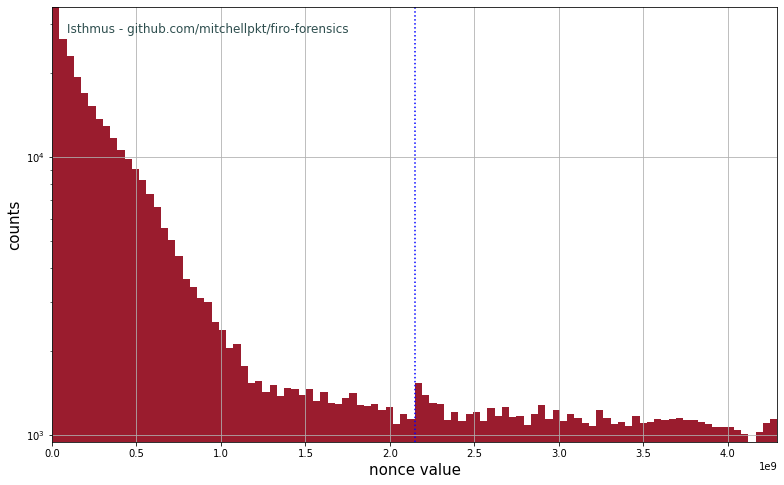

In [11]:
f = isli.hist(active_blocks['nonce'], bins=100, style=style, xlabel='nonce value', log_axes='y')
plt.axvline(x=max(active_blocks['nonce']) / 2, color='blue', linestyle=':');

To make sure that we're only taking into account relevant data we must ask whether the nonce search strategy changed over time?

Yes! A few observations from the below plot:
+ Between heights 7,500 (red line) and 21,000 (lime line) the dominant strategy appears to be a uniform search over *only* the bottom half of the nonce range. I don't think I have observed this in any other cryptocurrency.
+ Between heights 21,000 (lime line) and 120,000 (yellow line) the search was extended to cover the entire nonce range (uniformly).
+ While the strategy of iterating upwards from low nonces has always been present to some extent, it really picked up as the dominant strategy around height 120,000 (yellow line) onwards. (You can also see the subtle trace of the middle-upwards strategy).

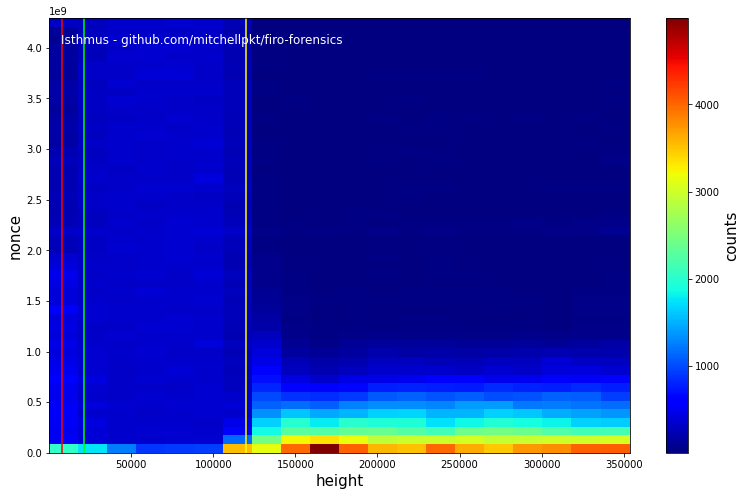

In [12]:
isli.hist2d(active_blocks['height'], active_blocks['nonce'], xlabel='height', ylabel='nonce',
            style=style.override({'watermark_color': 'white'}), bins=(20, 50), cmap='jet')
plt.axvline(x=7_500, color='red')
plt.axvline(x=21_000, color='lime')
plt.axvline(x=120_000, color='yellow');

### Attack block nonce distribution
It appears that the attacker was using software that employs the (dominant) strategy of starting at 0 and iterating upwards, as shown below

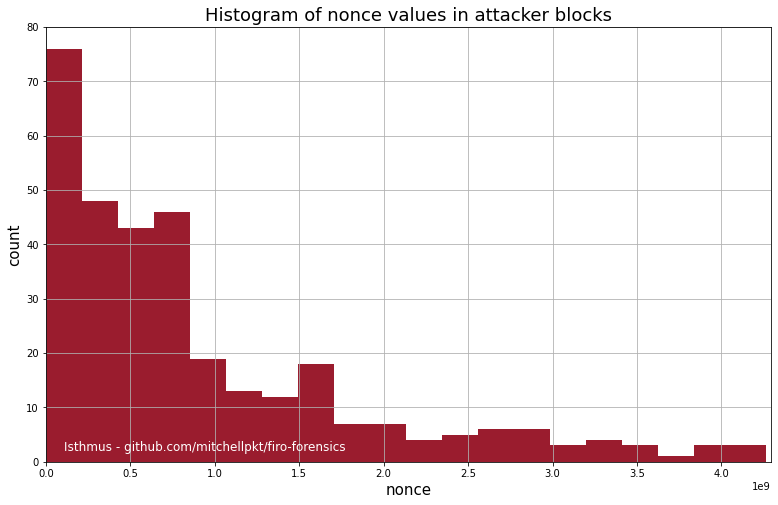

In [13]:
isli.hist(attack_blocks['nonce'], xlabel='nonce', ylabel='count', bins=20, xlim=(0, 2 ** 32), ylim=(0, 80),
          title='Histogram of nonce values in attacker blocks',
          style=style.override({'watermark_placement': alt_text_placement, 'watermark_color': 'w'}));

We want apples-to-apples comparisons when overlaying the nonce patterns, so we'll select our "control case" for nonce patterns from a 30,000 block window centered around the start of the attack, to remove historical artifacts. We also exclude the attacker's blocks.


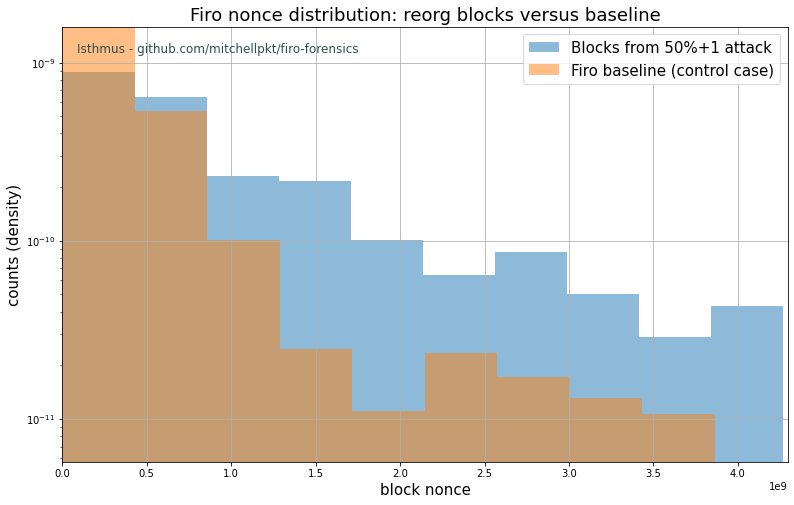

In [14]:
# Find the control blocks
window_width: int = 15_000  # blocks
first_attack_block: int = min(attack_blocks['height'])
last_attack_block: int = max(attack_blocks['height'])
window_left: int = first_attack_block - window_width // 2
window_right: int = first_attack_block + window_width // 2
control_blocks: pd.DataFrame = active_blocks.loc[active_blocks.height.between(window_left, window_right),
                               :].reset_index(drop=True)

# Plot the distribution of nonces on the control blocks and attack blocks over the attack timeframe
isli.hist([attack_blocks.nonce, control_blocks.nonce],
          legend_strings=['Blocks from 50%+1 attack', 'Firo baseline (control case)'], log_axes='y',
          density=True, xlabel='block nonce', bins=10, title='Firo nonce distribution: reorg blocks versus baseline',
          style=style, xlim=(0, 2 ** 32));

While the attacker and the control blocks both appear to use the same nonce search strategy of iterating upwards from zero, the slope of their discovered nonces differ significantly, which has subtle statistical implications. 

The control blocks have nonces weighted towards zero, because there are many independent workers all searching up from 0 together and it is likely that *somebody* will find a block sooner rather than later. 

The attack blocks have a less steep dropoff, which suggests that the hashrate was divided up between fewer workers (giving each a statistically greater chance of making it further through nonce range iteration).

**This suggests that the attacker's 50%+1 hashrate match came from *fewer* devices with *more* hashrate than the network average distribution (which effectively rules out a botnet attack, for example).**

(As an aside, we notice that in PoW networks with "iterate from zero" as the dominant search strategy, the steepness of the dropoff in the histogram is a statististical proxy for decentralization and the number of miner workers!! This is explored more thoroughly through simulations [here](https://github.com/Mitchellpkt/PoW-search-simulator/blob/main/PoW%20search%20simulator.ipynb))

The difference highlighted in the above histogram is visually apparent on a nonce scatter plot. See the change in density in the center of the graph? Those are the attackre's blocks; the fact that more of the search space was utilized during that small stretch is visible to the naked eye. (Second plot shows the duration of the attack boxed in blue, as a visual guide)


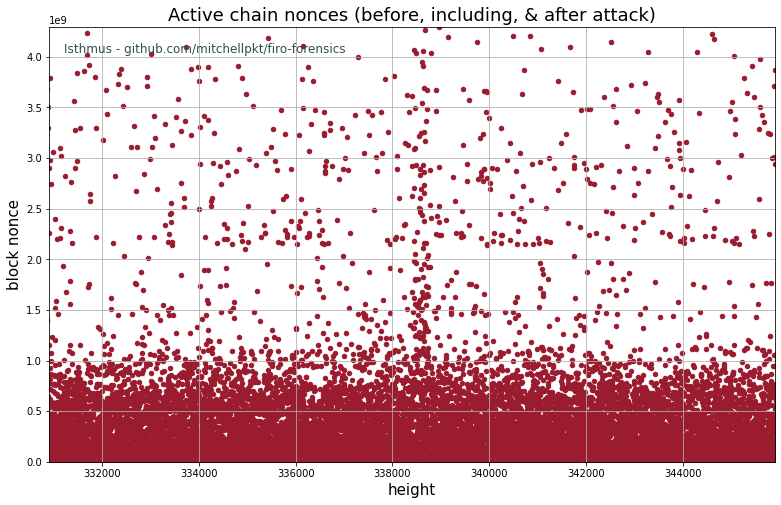

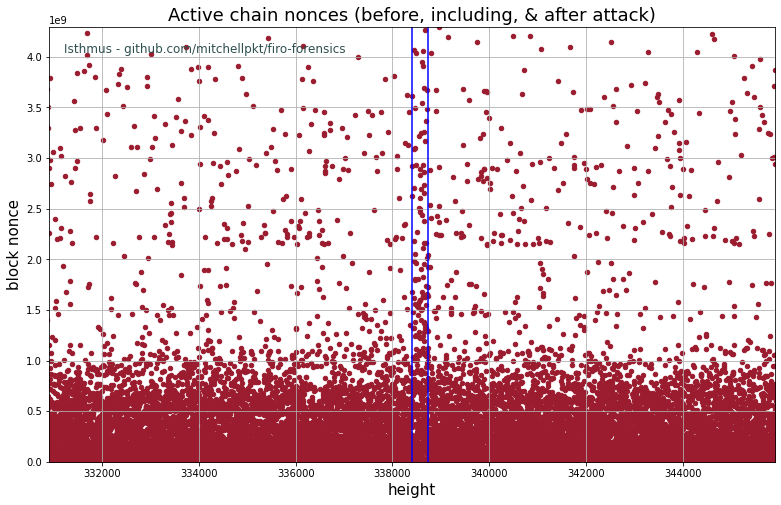

In [15]:
# Plot twice; once without visual aids, once with (blue lines)
isli.scatter(active_blocks['height'], active_blocks['nonce'], xlabel='height', ylabel='block nonce',
             xlim=(window_left, window_right), ylim=(min(active_blocks['nonce']), max(active_blocks['nonce'])),
             title='Active chain nonces (before, including, & after attack)', style=style.override({'markersize': 20}))
isli.scatter(active_blocks['height'], active_blocks['nonce'], xlabel='height', ylabel='block nonce',
             xlim=(window_left, window_right), ylim=(min(active_blocks['nonce']), max(active_blocks['nonce'])),
             title='Active chain nonces (before, including, & after attack)', style=style.override({'markersize': 20}))
plt.axvline(x=first_attack_block, color='b')
plt.axvline(x=last_attack_block, color='b');

## What was the hashrate of an individual worker?
With miners that increment (or decrement) the nonce with each hash, the hashrate of an individual worker can be estimated. In the case of incrementing upwards from zero, the calculation of hashrate (give or take latency and processing time) is trivial:

`worker_hashrate = nonce / block_discovery_time`

### Attacker estimated individual worker hashrate

First some quick feature engineering

In [16]:
def add_features(df: pd.DataFrame, allow_duplicates: bool = False) -> None:
    df.sort_values(by='time', ascending=True, ignore_index=True, inplace=True)
    df.insert(1, 'discovery_time', df.loc[:, 'time'].diff(), allow_duplicates)
    df.insert(1, 'estimated_hashes_per_sec', df.loc[:, 'nonce'] / df.loc[:, 'discovery_time'], allow_duplicates)
    df.insert(1, 'estimated_khashes_per_sec', df.loc[:, 'estimated_hashes_per_sec'] / 1000, allow_duplicates)


attacker_heights: List[int] = list(set(range(338403, 338760 + 1)) - set(others_heights))
attacker_blocks_df: pd.DataFrame = active_blocks.loc[[h in attacker_heights for h in active_blocks.height], :]
add_features(attacker_blocks_df)

nonce_threshold: float = 1e9  # << threshold for filtering nonces from non-iterative strategies
honest_blocks_df_all: pd.DataFrame = control_blocks.append(abandoned_blocks, ignore_index=True)
honest_blocks_df: pd.DataFrame = honest_blocks_df_all.loc[honest_blocks_df_all.nonce.astype(int) < nonce_threshold, :]
add_features(honest_blocks_df)
honest_heights: List[int] = honest_blocks_df.loc[:, 'height'].to_list()

/home/mglrnd/Projects/GitHub/firo-forensics/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Visualize results

In [17]:
def hashrate_estimates_text(df: pd.DataFrame) -> str:
    s: str = ""
    s += f"Number of blocks: {len(df)}\n"
    s += f"Median discovery time: {np.nanmedian(df['discovery_time'])} s\n"
    s += f"Median estimated hashrate: {np.nanmedian(df['estimated_hashes_per_sec'] / 1000):.0f} kH/s\n"
    s += f"Median worker hashrate for (kH/s): {np.nanmedian(df['estimated_khashes_per_sec']):.0f}\n"
    s += f"Mean worker hashrate for (kH/s): {np.nanmean(df['estimated_khashes_per_sec']):.0f}\n"
    return s


def hashrate_estimates_plot(df: pd.DataFrame, **kwargs) -> plt.Figure:
    return isli.scatter(df['height'][1::].to_list(),
                        df['estimated_khashes_per_sec'][1::].to_list(),
                        **kwargs)

### Attacker chain estimated individual worker hashrate

Number of blocks: 358
Median discovery time: 210.0 s
Median estimated hashrate: 2670 kH/s
Median worker hashrate for (kH/s): 2670
Mean worker hashrate for (kH/s): 19050



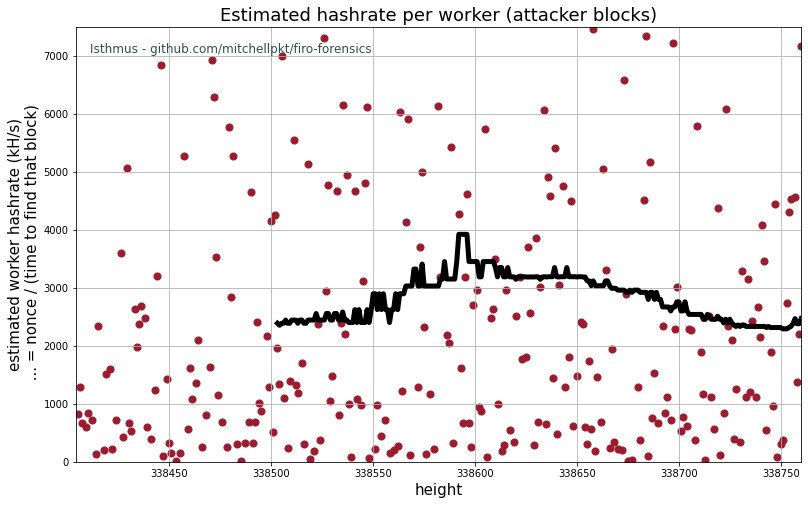

In [18]:
print(hashrate_estimates_text(attacker_blocks_df))
hashrate_estimates_plot(attacker_blocks_df, xlabel='height', rolling_median_width=100, ylim=[0, 7_500],
                        ylabel='estimated worker hashrate (kH/s)\n ... = nonce / (time to find that block)',
                        title='Estimated hashrate per worker (attacker blocks)', log_axes='',
                        style=style.override({'median_linewidth': 5}));

### Honest chain estimated individual worker hashrate

Number of blocks: 14343
Median discovery time: 217.0 s
Median estimated hashrate: 1021 kH/s
Median worker hashrate for (kH/s): 1021
Mean worker hashrate for (kH/s): 4027



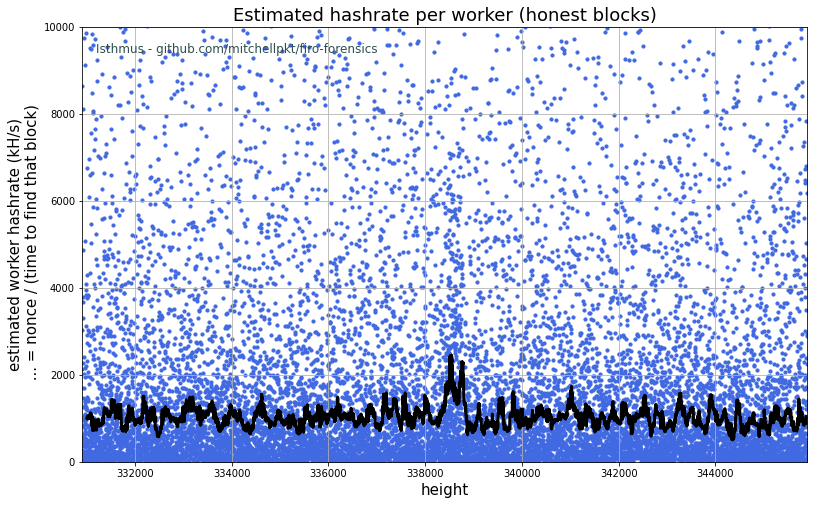

In [19]:
print(hashrate_estimates_text(honest_blocks_df))
hashrate_estimates_plot(honest_blocks_df, xlabel='height', rolling_median_width=100, ylim=(0, 1e4),
                        ylabel='estimated worker hashrate (kH/s)\n ... = nonce / (time to find that block)',
                        title='Estimated hashrate per worker (honest blocks)', log_axes='',
                        style=style.override({'markersize': 10, 'color': 'royalblue'}));

### Combined plots

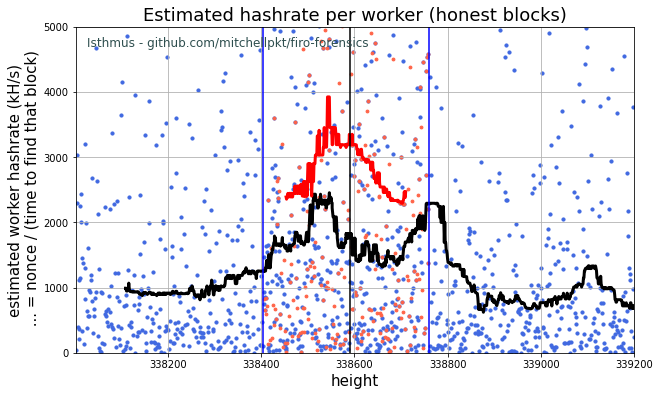

In [20]:
rolling_average_width: int = 100
hashrate_estimates_plot(honest_blocks_df.loc[honest_blocks_df.height.between(338000, 339200), :],
                        xlabel='height', rolling_median_width=100, ylim=(0, 5e3),
                        ylabel='estimated worker hashrate (kH/s)\n ... = nonce / (time to find that block)',
                        title='Estimated hashrate per worker (honest blocks)', log_axes='',
                        style=style.override({'markersize': 10, 'color': 'royalblue', 'figsize': (10, 6)}), )

# Now add the attacker blocks
plt.scatter(attacker_blocks_df['height'][1::], attacker_blocks_df['estimated_hashes_per_sec'][1::] / 1000,
            color='tomato', s=8)
temp_df: pd.DataFrame = pd.DataFrame({'x': attacker_blocks_df['height'][1::] - rolling_average_width / 2,
                                      'y': attacker_blocks_df['estimated_hashes_per_sec'][1::] / 1000})
temp_df.sort_values(by='x', ascending=True, inplace=True)
plt.plot(temp_df.x, temp_df['y'].rolling(rolling_average_width).median(), color='red', linewidth=3)
plt.axvline(x=338590, color='k')
plt.axvline(x=min(attacker_blocks_df['height']), color='b')
plt.axvline(x=max(attacker_blocks_df['height']), color='b');

## Cross-chain timestamp analysis
**Everything in this section must be prefaced with the caveat that block timestamps are entirely spoofable, so this could have been faked.**

The timestamps appear to show an organic trend which suggests to that the attacker did not take deliberate steps to falsify the timestamps. This means we can examine their block production schedule and thus make inferences about their hashrate. If this is true, then it appears they had roughly 51% to 55%(?) of the global hashrate at the time of the attack.

Imagine that the attacker had no new equipment/hashrate, but controlled 50%+1 of the equipment that was already active. In this case, when the attack starts, the rate of block production would be cut in half (which would cause the slope of the abandoned blocks to be cut in half from the the slope observed outside of the attack). 

The above scenario is NOT what is observed in the data. The below plot shows that the block production schedule of the original (abandoned)  chain did not change during the attack (between red lines). **This tells us that for the most part, the attacker had fresh equipment/hashrate that was not mining on the main chain immediately before or after the attack.**

(Note that around height 338550 there is in fact a small dip in the honest hashrate when the attacker's hashrate picks up some steam. This is a small delta and the statistical significance is unclear (it is not explored further here). If anything, it would mean that a small amount of organic hashrate joined the attacker partway through, however this would require back channel communication and coordination since the chain was not public at the time.)


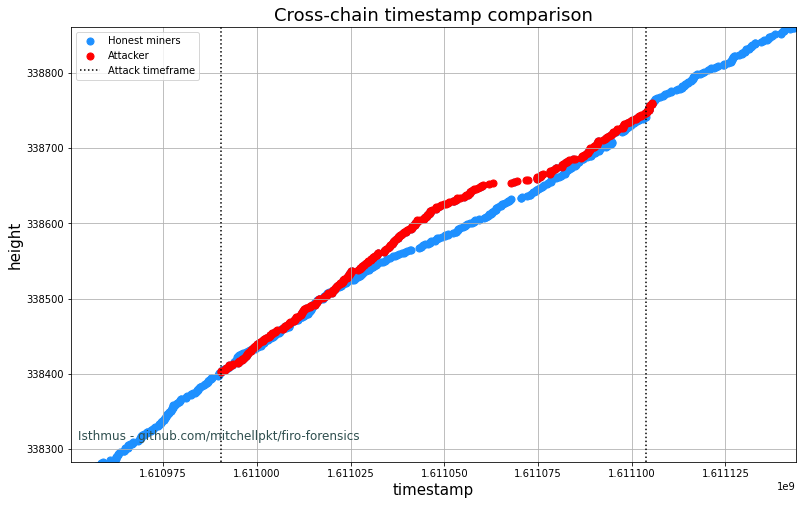

In [21]:
isli.scatter([honest_blocks_df.time, attacker_blocks_df.time], [honest_blocks_df.height, attacker_blocks_df.height],
             legend_strings=['Honest chain', "Attacker's chain"], xlabel='timestamp', ylabel='height',
             xlim=(min(abandoned_blocks['time']) - (t_buffer := 40_000), max(abandoned_blocks['time']) + t_buffer),
             ylim=(min(abandoned_blocks['height']) - (h_buffer := 120),
                   max(abandoned_blocks['height']) + h_buffer),
             style=style.override({'cycler': cycler(color=['dodgerblue', 'r']), 'watermark_placement': (0.01, 0.05)}),
             title='Cross-chain timestamp comparison',
             )
plt.axvline(x=min(abandoned_blocks['time']), color='k', linestyle=':')
plt.legend(('Honest miners', 'Attacker', 'Attack timeframe'))
plt.axvline(x=max(abandoned_blocks['time']), color='k', linestyle=':');

Let's look at the difference between the above two lines. In other words, when the honest chain was at height `h` how many blocks ahead or behind was the attacker. This will require a bit of data wrangling...

### Analysis data frame feature engineering
At a given time, calculate how far ahead or behind he attacker was

In [22]:
# initialize
time_values: List[int] = []
abandoned_height_values: List[int] = []
attacker_height_values: List[int] = []
analysis_df = pd.DataFrame()

for row_index in range(len(abandoned_blocks)):
    # Compare the chains
    time_abandoned_chain = abandoned_blocks['time'][row_index]
    height_abandoned_chain = abandoned_blocks['height'][row_index]
    attack_thus_far = attack_blocks.loc[attack_blocks['time'] <= time_abandoned_chain, :]
    if len(attack_thus_far) > 0:
        # Append to buffers
        time_values.append(time_abandoned_chain)
        abandoned_height_values.append(height_abandoned_chain)
        attacker_height_values.append(max(attack_thus_far['height']))

# Update dataframe
analysis_df.insert(0, 'time', time_values, False)
analysis_df.insert(0, 'abandoned_height', abandoned_height_values, False)
analysis_df.insert(0, 'attacker_height', attacker_height_values, False)
analysis_df.insert(0, 'attacker_lead', analysis_df['attacker_height'] - analysis_df['abandoned_height'], False)

### Attack progress visualization

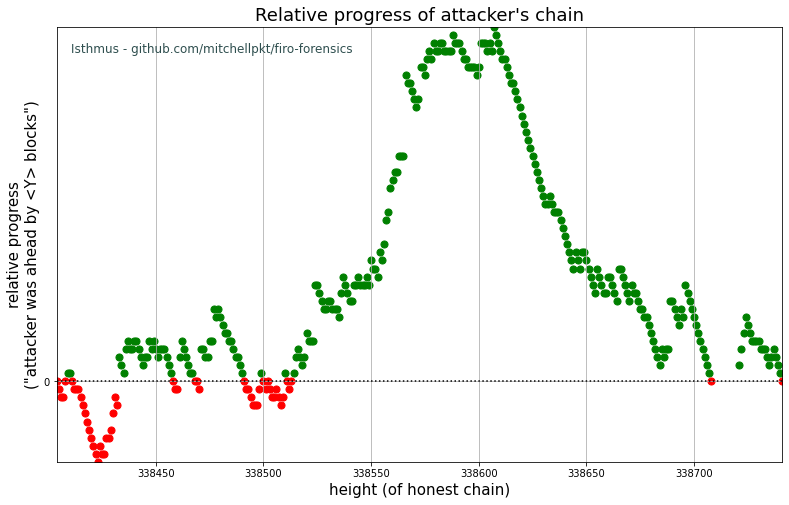

In [23]:
filter = analysis_df.attacker_lead > 0
isli.scatter([analysis_df.abandoned_height[filter].tolist(), analysis_df.abandoned_height[~filter].tolist()],
             [analysis_df.attacker_lead[filter].tolist(), analysis_df.attacker_lead[~filter].tolist()],
             xlabel='height (of honest chain)', ylabel='relative progress\n("attacker was ahead by <Y> blocks")',
             title="Relative progress of attacker's chain", style=style.override({'cycler': cycler(color=['g', 'r'])}));
plt.axhline(y='0', color='k', linestyle=':');

There's a few things to unpack with the above figure. 

For the first third of the attack, it appears that the attacker had about as much hashrate as the honest chain. In some cases the attacker fell behind by as much as 10 blocks but continued to persevere.

Around height 338510 it appears that the attacker's hashrate relative to the honest chain increased significantly, and they achieved a lead of 44 blocks at one point! 

Shortly after achieving the peak, the attacker's lead starts to wane, as their block production rate slowed relative to the honest chain.

Note / recall that although the reorgs stopped  at 338741, the attacker continued to be the dominant miner through block 338760 (the next 19 blocks ~ 1.5 hrs)


### Investigate the hashrate estimates

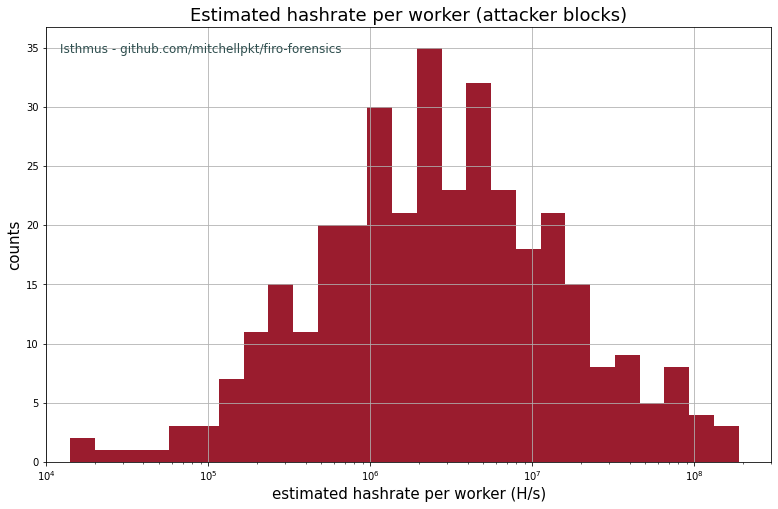

In [24]:
outlier_filter: pd.Series = attacker_blocks_df['estimated_hashes_per_sec'] < 2e8
isli.hist(attacker_blocks_df.estimated_hashes_per_sec[outlier_filter].tolist(), bins=30, log_axes='x',
          xlabel='estimated hashrate per worker (H/s)', title='Estimated hashrate per worker (attacker blocks)',
          xlim=(xlims := (1e4, 3e8)), style=style.override({'tight_axes':False}));

In [25]:
attacker_blocks_df[outlier_filter].describe().drop(columns=['time', 'estimated_khashes_per_sec'])

,height,estimated_hashes_per_sec,discovery_time,nonce
count,352.000000,3.520000e+02,352.000000,3.520000e+02
mean,338582.747159,1.100235e+07,326.943182,8.779349e+08
std,103.219409,2.495089e+07,419.847119,9.005293e+08
min,338404.000000,6.991539e+03,6.000000,1.244494e+06
25%,338494.750000,8.058751e+05,79.500000,2.327673e+08
50%,338583.500000,2.601451e+06,212.500000,5.739622e+08
75%,338671.250000,8.450506e+06,421.250000,1.200292e+09
max,338760.000000,1.885439e+08,4711.000000,4.266500e+09


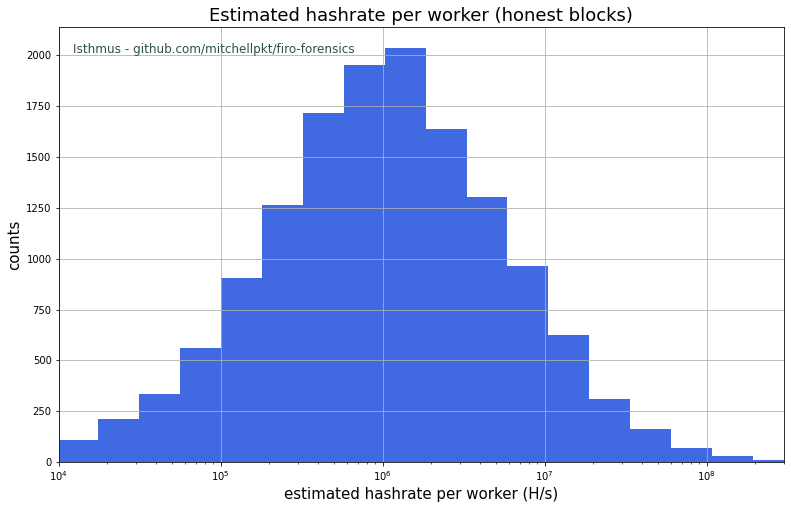

In [26]:
isli.hist(honest_blocks_df.estimated_hashes_per_sec.dropna().tolist(), bins=30, log_axes='x',
          xlabel='estimated hashrate per worker (H/s)', title='Estimated hashrate per worker (honest blocks)',
          style=style.override({'color': 'royalblue', 'tight_axes':False}), xlim=xlims);

In [27]:
attacker_blocks_df[outlier_filter].describe().drop(columns=['time', 'estimated_khashes_per_sec'])

,height,estimated_hashes_per_sec,discovery_time,nonce
count,352.000000,3.520000e+02,352.000000,3.520000e+02
mean,338582.747159,1.100235e+07,326.943182,8.779349e+08
std,103.219409,2.495089e+07,419.847119,9.005293e+08
min,338404.000000,6.991539e+03,6.000000,1.244494e+06
25%,338494.750000,8.058751e+05,79.500000,2.327673e+08
50%,338583.500000,2.601451e+06,212.500000,5.739622e+08
75%,338671.250000,8.450506e+06,421.250000,1.200292e+09
max,338760.000000,1.885439e+08,4711.000000,4.266500e+09
